In [1]:
#Read training data
import pandas as pd
fileName = "trainData.csv"
df = pd.read_csv(fileName, sep = ',')

In [2]:
df.head()

,ID,O,C,H,L,V,BV,Mean,T,MarketName,Reward
0,1,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878,-0.008966,2015-12-15,BTC-ETH,-0.896561
1,1,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358,0.005236,2015-12-16,BTC-ETH,0.523557
2,1,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502,-0.064499,2015-12-17,BTC-ETH,-6.449900
3,1,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244,-0.038707,2015-12-18,BTC-ETH,-3.870695
4,1,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657,-0.031732,2015-12-19,BTC-ETH,-3.173201


In [3]:
colnames = ['T','O','C','H','L','V','BV']
reward_cols = ['T','Reward']

In [4]:
eth = df[(df['MarketName'] == 'BTC-ETH')][colnames]
xrp = df[(df['MarketName'] == 'BTC-XRP')][colnames]
ltc = df[(df['MarketName'] == 'BTC-LTC')][colnames]
xlm = df[(df['MarketName'] == 'BTC-XLM')][colnames]
usd = df[(df['MarketName'] == 'USDT-BTC')][colnames]

In [5]:
eth.head()

,T,O,C,H,L,V,BV
0,2015-12-15,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878
1,2015-12-16,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358
2,2015-12-17,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502
3,2015-12-18,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244
4,2015-12-19,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657


In [6]:
eth_reward = df[(df['MarketName'] == 'BTC-ETH')][reward_cols]
xrp_reward = df[(df['MarketName'] == 'BTC-XRP')][reward_cols]
ltc_reward = df[(df['MarketName'] == 'BTC-LTC')][reward_cols]
xlm_reward = df[(df['MarketName'] == 'BTC-XLM')][reward_cols]
usd_reward = df[(df['MarketName'] == 'USDT-BTC')][reward_cols]
usd_reward.loc[:,'Reward'] *= -1 # Because we used tether reward

In [7]:
eth_reward.head()

,T,Reward
0,2015-12-15,-0.896561
1,2015-12-16,0.523557
2,2015-12-17,-6.449900
3,2015-12-18,-3.870695
4,2015-12-19,-3.173201


In [8]:
merged1 = pd.merge(eth, xrp, on = 'T', suffixes=('_eth', '_xrp'))
merged2 = pd.merge(ltc, xlm, on = 'T', suffixes=('_ltc', '_xlm'))
merged = pd.merge(merged1, merged2, on = 'T')
merged = pd.merge(merged, usd, on = 'T')
merged.head()

,T,O_eth,C_eth,H_eth,L_eth,V_eth,BV_eth,O_xrp,C_xrp,H_xrp,...,H_xlm,L_xlm,V_xlm,BV_xlm,O,C,H,L,V,BV
0,2015-12-15,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878,-0.250256,-0.100416,-0.212046,...,-0.043933,-0.144351,1029.180334,885.502597,0.000000,0.071429,0.071429,0.000000,1320.637261,1410.396749
1,2015-12-16,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358,-0.111491,0.131640,-0.027795,...,-0.052516,0.000000,-0.521941,-0.507073,0.071429,0.002222,0.044444,0.071429,-0.815032,-0.810448
2,2015-12-17,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502,0.131640,-0.024490,-0.025341,...,-0.055427,0.000000,-0.992587,-0.992851,0.071429,0.002222,0.044444,0.071429,-0.815032,-0.810448
3,2015-12-18,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244,-0.040816,-0.056485,-0.054000,...,0.058680,0.019560,1.314162,1.401100,0.020000,0.017738,-0.023404,0.020000,-0.999841,-0.999841
4,2015-12-19,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657,-0.036879,-0.002956,-0.038055,...,-0.053118,-0.098321,11.826813,10.635375,-0.017429,-0.017429,-0.017429,-0.017429,863.027096,847.967800


# REINFORCEMENT LEARNING SETTINGS

In [9]:
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.preprocessing import MinMaxScaler
from random import randint

Using TensorFlow backend.


In [29]:
EPISODES = 100

class TradingAction(object):
    ETH = 0
    XRP = 1
    LTC = 2
    XLM = 3
    USD = 4
    BTC = 5
    
class TradingEnv:
  def __init__(self):
    #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
    pass

  def reset(self):
    pass

  def __init__(self):
    #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
    pass

  def step(self, action, date):
    reward = 0
    if action == TradingAction.ETH:
        reward = eth_reward[(eth_reward['T'] == date)]['Reward']
    if action == TradingAction.XRP:
        reward = xrp_reward[(xrp_reward['T'] == date)]['Reward']
    if action == TradingAction.LTC:
        reward = ltc_reward[(ltc_reward['T'] == date)]['Reward']
    if action == TradingAction.XLM:
        reward = xlm_reward[(xlm_reward['T'] == date)]['Reward']
    if action == TradingAction.USD:
        reward = usd_reward[(usd_reward['T'] == date)]['Reward']
    if action == TradingAction.BTC:
        reward = 0 # Do nothing action
    return reward

In [35]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.0001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(200, input_dim=self.state_size, activation='relu'))
        model.add(Dense(200, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            '''
            if not done:
                temp_pred = np.amax(self.model.predict(next_state)[0])
                target = (reward + self.gamma * temp_pred)
                target = target.item()
            '''
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [36]:
#Split as Train and Test data
row_count = merged.shape[0]
split_point = int(row_count - 10)
train_data, test_data = merged[:split_point], merged[split_point:]
test_data.head()

,T,O_eth,C_eth,H_eth,L_eth,V_eth,BV_eth,O_xrp,C_xrp,H_xrp,...,H_xlm,L_xlm,V_xlm,BV_xlm,O,C,H,L,V,BV
1240,2019-05-08,-0.039260,-0.009551,-0.070137,-0.015567,0.268679,0.223918,-0.027936,-0.017062,-0.028950,...,-0.062573,-0.038437,0.296585,0.235338,0.016744,0.021961,-0.000040,0.006330,-0.288153,-0.289312
1241,2019-05-09,-0.011812,-0.036035,-0.020782,-0.039529,-0.127683,-0.153176,-0.022287,-0.049481,0.001559,...,-0.036182,-0.068152,0.965237,0.869732,0.024583,0.032258,0.030954,0.035088,0.561178,0.605267
1242,2019-05-10,-0.032461,-0.019719,-0.014434,-0.009875,0.819884,0.787911,-0.048190,-0.017632,-0.058755,...,-0.042718,-0.021800,-0.459246,-0.472555,0.033010,0.032457,0.040658,0.024874,0.487902,0.541982
1243,2019-05-11,-0.019590,-0.014127,0.018695,-0.055754,0.824503,0.812566,-0.014916,-0.047436,-0.003100,...,0.012170,-0.020129,2.117889,2.124650,0.030626,0.127441,0.144436,0.038907,0.580096,0.735396
1244,2019-05-12,-0.014262,0.008898,-0.050253,0.025882,-0.456344,-0.467268,-0.046492,-0.002019,-0.062409,...,-0.036740,0.001467,-0.550315,-0.563699,0.128721,-0.026778,0.017521,0.065637,0.131636,0.159973


In [37]:
#Preprocess Data
scaler = MinMaxScaler()
scaled_cols = ['O_eth','C_eth','H_eth','L_eth','V_eth','BV_eth','O_xrp','C_xrp','H_xrp','L_xrp','V_xrp','BV_xrp','O_ltc','C_ltc','H_ltc','L_ltc','V_ltc','BV_ltc','O_xlm','C_xlm','H_xlm','L_xlm','V_xlm','BV_xlm','O','C','H','L','V','BV']
scaler.fit(train_data[scaled_cols])
train_data.iloc[:][scaled_cols] = scaler.transform(train_data[scaled_cols])
#Use same scaler to transform test data
test_data.iloc[:][scaled_cols] = scaler.transform(test_data[scaled_cols])

In [38]:
train_data.head()

,T,O_eth,C_eth,H_eth,L_eth,V_eth,BV_eth,O_xrp,C_xrp,H_xrp,...,H_xlm,L_xlm,V_xlm,BV_xlm,O,C,H,L,V,BV
0,2015-12-15,0.442294,0.378528,0.364552,0.428364,0.052847,0.053281,0.109463,0.175298,0.049073,...,0.134094,0.002061,4.322030e-02,3.154945e-02,0.412240,0.570424,0.638054,0.409259,9.796437e-03,9.717054e-03
1,2015-12-16,0.362899,0.415824,0.423727,0.404799,0.056164,0.056314,0.170113,0.277759,0.116677,...,0.130595,0.002409,2.001161e-05,1.750484e-05,0.569013,0.418152,0.571256,0.496974,1.371000e-06,1.304971e-06
2,2015-12-17,0.442582,0.316062,0.258978,0.383128,0.019742,0.018800,0.276379,0.208822,0.117578,...,0.129408,0.002409,2.660729e-07,2.166164e-07,0.569013,0.418152,0.571256,0.496974,1.371000e-06,1.304971e-06
3,2015-12-18,0.321294,0.349746,0.272538,0.444088,0.019224,0.018233,0.201003,0.194695,0.107062,...,0.175928,0.002457,9.704375e-05,8.541427e-05,0.456136,0.452291,0.403299,0.433819,1.135148e-09,1.054243e-09
4,2015-12-19,0.354857,0.399185,0.325240,0.404743,0.040113,0.040105,0.202724,0.218330,0.112913,...,0.130349,0.002172,5.380931e-04,4.140502e-04,0.373986,0.374913,0.418090,0.387856,6.404471e-03,5.844895e-03


In [39]:
#TRAIN AGENT
observation_cols = ['O_eth','C_eth','H_eth','L_eth','V_eth','BV_eth','O_xrp','C_xrp','H_xrp','L_xrp','V_xrp','BV_xrp','O_ltc','C_ltc','H_ltc','L_ltc','V_ltc','BV_ltc','O_xlm','C_xlm','H_xlm','L_xlm','V_xlm','BV_xlm','O','C','H','L','V','BV']
state_size = len(observation_cols)
action_size = 6 #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
env = TradingEnv()
agent = DQNAgent(state_size, action_size)
# agent.load("./save/trading-dqn.h5")

done = False
batch_size = 32
best_score = 0
best_action = 0
best_reward = -100000

for e in range(EPISODES):
    total_reward = 0
    for idx in range(len(train_data)-1):
        state = train_data.iloc[idx][observation_cols]
        state = np.reshape([state], [1, state_size])
        
        action = agent.act(state)
        reward = env.step(action, train_data.iloc[idx+1]['T'])
        
        next_state = train_data.iloc[idx+1][observation_cols]
        next_state = np.reshape([next_state], [1, state_size])
        
        if isinstance(reward, int) == False:
            reward = reward.item()
            
        agent.remember(state, action, reward, next_state, done)
        total_reward = total_reward + reward
        if total_reward >= best_reward:
            best_reward = total_reward
            best_action = action
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    print("episode: {}, best_reward: {}, total_reward: {}" .format(e, best_reward, total_reward))


episode: 0, best_reward: 181.9140893088542, total_reward: 144.31190535893623


In [14]:
#Save Agent
agent.save("./save/trading-dqn.h5")

In [40]:
#TEST AGENT
done = False
batch_size = 32
test_reward = 0
reward_list = []
for idx in range(len(test_data)-1):
    state = test_data.iloc[idx][observation_cols]
    state = np.reshape([state], [1, state_size])

    action = agent.act(state)
    reward = env.step(action, test_data.iloc[idx+1]['T'])
    if isinstance(reward, int) == False:
        reward = reward.item()
    test_reward = test_reward + reward 
    reward_list.append(reward)
print("Test_reward: {}" .format(test_reward))

Test_reward: 20.714215940278677


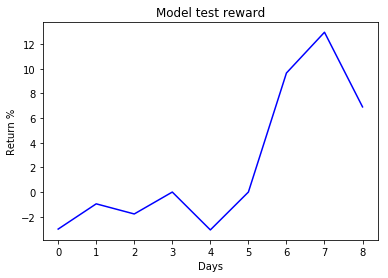

In [41]:
#Plot rewards
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(0,len(test_data)-1,1),reward_list, c='b')
plt.title('Model test reward')
plt.ylabel('Return %')
plt.xlabel('Days')
plt.show()

In [42]:
index = -2
print(merged.iloc[index]['T'])
state = merged.iloc[index][observation_cols]
state = np.reshape([state], [1, state_size])
act_values = agent.model.predict(state)
print(act_values)
print("Best action",np.argmax(act_values[0]))
print("Best reward",np.max(act_values[0]))
#Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc

2019-05-16
[[-2.078688   -2.342142   -0.3109841   0.02214996 -1.33411     0.30554634]]
Best action 5
Best reward 0.30554634


In [43]:
index = -1
print(eth_reward.iloc[index]['T'])
r1 = eth_reward.iloc[index]['Reward'].item()
r2 = xrp_reward.iloc[index]['Reward'].item()
r3 = ltc_reward.iloc[index]['Reward'].item()
r4 = xlm_reward.iloc[index]['Reward'].item()
r5 = usd_reward.iloc[index]['Reward'].item()
print("eth: {}, xrp: {}, ltc: {}, xlm: {}, usd: {}, btc: {}" .format(r1, r2, r3, r4, r5, 0))

2019-05-17
eth: 1.1511711702589098, xrp: -4.0062626634739305, ltc: -0.8117926408226178, xlm: -5.76289791437979, usd: 6.90661447150133, btc: 0
